# SENTIMENT ANALYSIS
This project seeks to analyze and develop a predictive model of the sentiments derived from tweets by random people about google products and Apple. The emotions from the tweets are either positive, negative or neutral. We seek to create a binary classifier model and a multi-class model. The binary classifier will determine whether a tweet is positive or negative towards a product while the multi-class will include the neutral emotion. The natural language processing technique enables us easily determine whether a post depicts satisfaction or dissatisfaction without having to go through the entire posts and this makes the process scalable,and that is the end goal for this project.
To develop the model we used the [data](https://data.world/crowdflower/brands-and-product-emotions) from data world collected by CrowdFlower.

## Data Description

In [1]:
# importing the libraries used in this model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import nltk
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import RegexpTokenizer, stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# reading the dataset and viewing the first 5 rows
data = pd.read_csv('Twitter_Sentiments_Data.csv')
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [3]:
# Getting the information about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [4]:
# Getting to see if there are null values in the data
data.isnull().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [5]:
# to see the number of rows and columns in the data
data.shape

(9093, 3)

In [6]:
# to get to show the number and labels of classes in the data
data['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64

The data has three columns the tweet_text column contains the tweets, the emotion_in_tweet_is_directed_at contains the brand to which the tweet was directed and the last column is_there_an_emotion_directed_at_a_brand_or_product has the emotion. There are 9093 rows in the data however there are 5802 null values in the second column and 1 in the first column.There are 4 values under the emotions column, positive, negative, neutral and unknown

## Data Cleaning and Visualizations

In [7]:
# rename the classes columns
data.rename(columns={'is_there_an_emotion_directed_at_a_brand_or_product':'sentiment'},inplace=True)

In [8]:
# dropped the null values in the tweet_texts column
data.dropna(subset='tweet_text',inplace=True)
# removed the 2nd column as it is not necessary for our model
data = data.drop(columns=['emotion_in_tweet_is_directed_at'])
# rename the sentiments
data['sentiment'] = data['sentiment'].replace({'No emotion toward brand or product':'Neutral emotion'})
# define a df with two sentiments
binary_df = data[data['sentiment'].isin(['Positive emotion','Negative emotion'])]
# define the multi class df
multi_df = data[data['sentiment'].isin(['Positive emotion','Negative emotion','Neutral emotion'])]

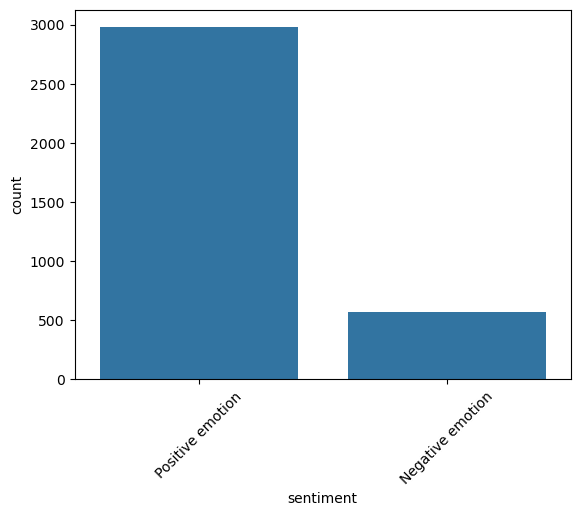

In [9]:
# Visualizing the sentiments distribution in binary df
sentiment_distribution = binary_df['sentiment'].value_counts()
fig, ax = plt.subplots()
sns.barplot(sentiment_distribution)
plt.xticks(rotation = 45);

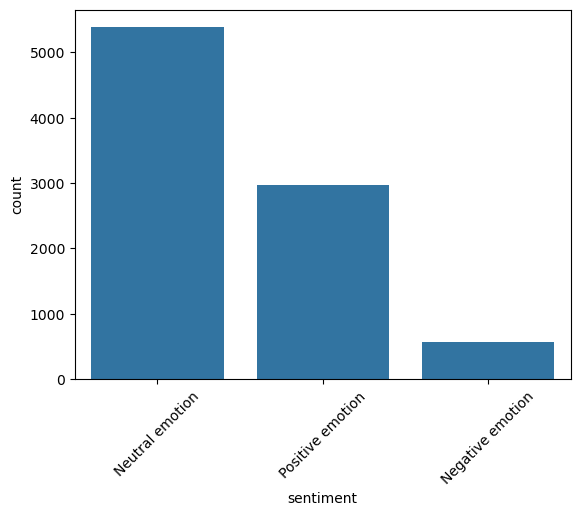

In [10]:
# Visualizing the sentiments distribution in multi df
sentiment_distribution = multi_df['sentiment'].value_counts()
fig, ax = plt.subplots()
sns.barplot(sentiment_distribution)
plt.xticks(rotation = 45);

## Data Preprocessing

In [11]:
# defining a preprocessing function. Note that the function will need inportation of a number of function
def text_preprocessor(text):
    # turn all the words into lower case
    text.lower()
    # tokenize 
    tokenizer = RegexpTokenizer(r'\b[a-zA-Z]+\b')
    tokens = tokenizer.tokenize(text)
    # remove the stop words
    stopwords_list = stopwords.words('english')
    stopped = [word for word in tokens if word not in stopwords_list]
    # stem the words
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stopped]
    return lemmatized_words

In [12]:
# testing the performance of the function
print(f'''This is the test text: \n{binary_df.iloc[0,0]}\n After applying the
function the result is:\n{text_preprocessor(binary_df.iloc[0,0])}''')

This is the test text: 
.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.
 After applying the
function the result is:
['I', 'iPhone', 'After', 'hr', 'tweeting', 'dead', 'I', 'need', 'upgrade', 'Plugin', 'station', 'SXSW']


In [13]:
# preprocessing the text
binary_df['preprocessed_text'] = binary_df['tweet_text'].apply(lambda x:text_preprocessor(x))
binary_df.head()

C:\Users\admin\AppData\Local\Temp\ipykernel_9980\3862744222.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary_df['preprocessed_text'] = binary_df['tweet_text'].apply(lambda x:text_preprocessor(x))


,tweet_text,sentiment,preprocessed_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion,"[I, iPhone, After, hr, tweeting, dead, I, need..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion,"[jessedee, Know, fludapp, Awesome, iPad, iPhon..."
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion,"[swonderlin, Can, wait, iPad, also, They, sale..."
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion,"[sxsw, I, hope, year, festival, crashy, year, ..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion,"[sxtxstate, great, stuff, Fri, SXSW, Marissa, ..."


In [14]:
# joining the text
binary_df['text']=binary_df['preprocessed_text'].str.join(' ')

C:\Users\admin\AppData\Local\Temp\ipykernel_9980\3420845869.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary_df['text']=binary_df['preprocessed_text'].str.join(' ')


# Modelling
After preprocessing the data we head on into the modelling bit, where we will make a binary and multi class model.

In [15]:
# making of the pipeline
pipe = Pipeline([('vectorizer', TfidfVectorizer()),
                 ('model',MultinomialNB())])

In [16]:
# splitting the data into train and test data
X_train,X_test,y_train,y_test = train_test_split(binary_df['text'],binary_df['sentiment'],test_size=0.25, random_state=132)

In [17]:
# fitting the binary model
pipe.fit(X_train,y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()), ('model', MultinomialNB())])

In [18]:
# to get the performance of the model
pipe.score(X_test,y_test)

0.8410372040586246

In [19]:
#using an advance classifying method
pipe.set_params(model = RandomForestClassifier())

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('model', RandomForestClassifier())])

In [20]:
# fitting the new model
pipe.fit(X_train,y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('model', RandomForestClassifier())])

In [21]:
# getting the score of the new model
pipe.score(X_test,y_test)

0.8635851183765502

In [22]:
# getting the predictions using the X_test
y_pred = pipe.predict(X_test)


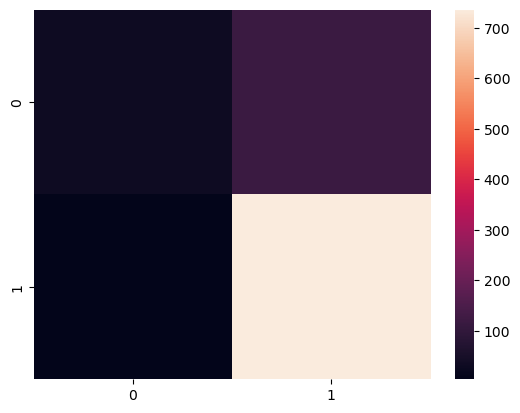

In [23]:
# showing the classification matrix
sns.heatmap(confusion_matrix(y_test,y_pred));

In [24]:
# the report
print(classification_report(y_test,y_pred))

                  precision    recall  f1-score   support

Negative emotion       0.88      0.20      0.33       147
Positive emotion       0.86      0.99      0.92       740

        accuracy                           0.86       887
       macro avg       0.87      0.60      0.63       887
    weighted avg       0.87      0.86      0.83       887



In [25]:
# preprocessing the text for the multi class
multi_df.loc[:,'preprocessed_text'] = multi_df['tweet_text'].apply(lambda x:text_preprocessor(x))
multi_df.head()

C:\Users\admin\AppData\Local\Temp\ipykernel_9980\4176010240.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multi_df.loc[:,'preprocessed_text'] = multi_df['tweet_text'].apply(lambda x:text_preprocessor(x))


,tweet_text,sentiment,preprocessed_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion,"[I, iPhone, After, hr, tweeting, dead, I, need..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion,"[jessedee, Know, fludapp, Awesome, iPad, iPhon..."
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion,"[swonderlin, Can, wait, iPad, also, They, sale..."
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion,"[sxsw, I, hope, year, festival, crashy, year, ..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion,"[sxtxstate, great, stuff, Fri, SXSW, Marissa, ..."


In [26]:
# joining the text
multi_df['text']=multi_df['preprocessed_text'].str.join(' ')

C:\Users\admin\AppData\Local\Temp\ipykernel_9980\34295771.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multi_df['text']=multi_df['preprocessed_text'].str.join(' ')


In [27]:
# splitting the data for multu class
X_train,X_test,y_train,y_test = train_test_split(multi_df['text'],multi_df['sentiment'],test_size=0.25, random_state=132)

In [28]:
# training the multi class model
pipe.fit(X_train,y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('model', RandomForestClassifier())])

In [29]:
# getting the score of the multi class model
pipe.score(X_test,y_test)

0.6799462846911369

In [30]:
# the report
print(classification_report(y_test,pipe.predict(X_test)))

                  precision    recall  f1-score   support

Negative emotion       0.72      0.20      0.31       148
 Neutral emotion       0.69      0.89      0.78      1350
Positive emotion       0.64      0.40      0.49       736

        accuracy                           0.68      2234
       macro avg       0.68      0.49      0.53      2234
    weighted avg       0.68      0.68      0.65      2234



## Conclusion
The models created can be used in predicting the multi_class and binary classes. The binary classifictaion model has a higher prediction score, with an F1 score of about 83% while the multi class model has a score of 66%. The F1 score is a bttere measure of the performance in this scenario as the classes are imbalanced.